In [2]:
from IPython.display import clear_output, Image, display, HTML
from collections import deque
%matplotlib inline
import matplotlib.pyplot as plt
import pygame as pygame
import numpy as np
import asyncio
import nest_asyncio
import random
import cv2
import os
import gc
nest_asyncio.apply()

pygame 2.1.3 (SDL 2.0.22, Python 3.10.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
import torch as t
import torch.nn as nn
from torchinfo import summary

In [4]:
os.environ["SDL_VIDEODRIVER"] = "dummy"
XRES = 800
YRES = 600
FACTOR = 4
XRES_SCALED = int(XRES / FACTOR)
YRES_SCALED = int(YRES / FACTOR)
STATE_DEPTH = 10
FRAME_SKIP = 4 # we drop a few frames , since is not efficient to use all frames of the game (most are very similar to each other)
TICKS_REF = 80
ACTION_SIZE = 4
STATE_SIZE = (1, STATE_DEPTH, 3, XRES_SCALED, YRES_SCALED)
BATCH_SIZE = 32
MEMORY_DEPTH = 500
SCREEN = pygame.display.set_mode((XRES, YRES))
MODEL_FILE = 'space_model_RNN.pt'
STATS_FILE = 'stats_RNN.txt'
LEARNING_RATE = 1e-5
EPSILON_DECAY =  0.9997

if t.cuda.is_available():
    DEVICE = t.device('cuda')
else:
    DEVICE = t.device('cpu')
print('DEVICE:', DEVICE)

DEVICE: cuda


In [5]:
from game import SpaceInvaders

In [6]:
class LSTM(nn.Module):
    def __init__(self, state_size_f, action_size, seq_size, hidden_cells=256, hidden_layers=5):
        super().__init__()
        self.state_size = state_size_f
        self.hidden_cells = hidden_cells
        self.hidden_layers = hidden_layers
        self.seq_size = seq_size
        self.lstm_layer = nn.LSTM(self.state_size, self.hidden_cells, self.hidden_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_cells * self.seq_size, action_size)
    
    def lstm_forward(self, x):
        out, (hx, cx) = self.lstm_layer(x)
        return self.fc(out.view(-1, self.hidden_cells * self.seq_size))

In [7]:
class convolution(LSTM):
    def __init__(self, state_size_i, action_size, seq_size, state_size_f):
        super().__init__(state_size_f, action_size, seq_size)
        self.state_size_i = state_size_i
        self.state_size_f = state_size_f
        self.action_size = action_size
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5,5), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(27648, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, state_size_f),
        )

In [8]:
class SpaceModel(convolution):
    def __init__(self, state_size_i, action_size, state_size_f):
        super().__init__(state_size_i=state_size_i[1:], action_size=action_size, seq_size=state_size_i[0], state_size_f=state_size_f)
        self.layers = nn.Sequential(self.conv_layer)
        self.optimizer = t.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.L1Loss()

    def forward(self, x):
        x = t.tensor(x).to(DEVICE)
        batch_size, time_steps, C, H, W = x.size()
        output = t.tensor([]).to(DEVICE)
        for i in range(time_steps): # same convolution to the 10 frames
            output_t = x[:, i, :, :, :]
            for l in self.layers:
                output_t = l(output_t)
            output = t.cat((output, output_t.unsqueeze(1)), 1) #stack 10 frames
        return self.lstm_forward(output)

    def fit(self, x, target):
        x = t.tensor(x).to(DEVICE)
        target = t.tensor(target).to(DEVICE)
        y_hat = self(x)
        loss = self.criterion(y_hat, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
model = SpaceModel(STATE_SIZE[1:], ACTION_SIZE, 256).to(DEVICE)
summary(model, STATE_SIZE)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10312\179974043.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = t.tensor(x).to(DEVICE)


Layer (type:depth-idx)                   Output Shape              Param #
SpaceModel                               [1, 4]                    --
├─Sequential: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 256]                  --
│    │    └─Conv2d: 3-1                  [1, 32, 198, 148]         2,432
│    │    └─ReLU: 3-2                    [1, 32, 198, 148]         --
│    │    └─MaxPool2d: 3-3               [1, 32, 99, 74]           --
│    │    └─Dropout: 3-4                 [1, 32, 99, 74]           --
│    │    └─Conv2d: 3-5                  [1, 64, 99, 74]           18,496
│    │    └─ReLU: 3-6                    [1, 64, 99, 74]           --
│    │    └─MaxPool2d: 3-7               [1, 64, 49, 37]           --
│    │    └─Dropout: 3-8                 [1, 64, 49, 37]           --
│    │    └─Conv2d: 3-9                  [1, 128, 49, 37]          73,856
│    │    └─ReLU: 3-10                   [1, 128, 49, 37]          --
│   

In [10]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.state_depth = STATE_DEPTH
        self.memory = deque(maxlen=MEMORY_DEPTH)
        self.memory_count = 0
        self.frame_memory = deque(maxlen=self.state_depth)
        self.frame_count = 0
        self.frame_skip = FRAME_SKIP
        self.reward_memory = deque(maxlen=self.frame_skip*self.state_depth)
        self.gamma = 0.997 # discount rate
        self.epsilon = 0.95 # initial exploration rate
        self.epsilon_min = 0.00
        self.epsilon_decay = EPSILON_DECAY
        self.model = SpaceModel(state_size[1:], action_size, 256).to(DEVICE)
        self.target_model = SpaceModel(state_size[1:], action_size, 256).to(DEVICE)
        self.training = True
        self.train_step = 0
        self.train_step_update = 100
    
    def set_train(self, enable):
        self.training = enable
        if not self.training:
            self.epsilon = 0.0
    
    def clear(self):
        self.frame_memory.clear()
        self.reward_memory.clear()
        self.frame_count = 0
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action_id = random.randrange(self.action_size)
        else:
            action = self.model(state).cpu()
            action = action.detach().numpy()
            action_id = np.argmax(action[0])
            print(action_id, action)
        return action_id
    
    def replay(self, batch_size):
        if not self.training:
            return
        
        idx_range = range(0, len(self.memory), 1)
        batch_reward = []
        for idx in random.sample(idx_range, batch_size):
            current = self.memory[idx]
            states = current[0]
            action = current[1]
            reward = current[2]
            nexts = current[3]
            done = current[4]

            batch_reward.append(reward)
            target = reward
            if not done:
                q_val = self.target_model(nexts).cpu()
                q_val = q_val.detach().numpy()
                target = (reward + self.gamma * np.amax(q_val[0]))
            target_f = self.model(states)
            target_f[0][action] = target
            self.model.fit(states, target_f)
        batch_reward = np.mean(batch_reward)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.memory_count = 0
        return batch_reward
            
    def play(self, game):
        initial_state = game.get_state(action=0)

        #append dummy frames in the beggining of game
        for _ in range(self.state_depth - len(self.frame_memory)):
            self.frame_memory.append(np.array(initial_state))

        self.frame_count += 1
        if self.frame_count % self.frame_skip == 0:
            self.frame_memory.append(np.array(initial_state))
            new_action = True
        else:
            new_action = False

        i_state = np.array(self.frame_memory.copy())[np.newaxis, :]

        action = self.act(i_state)

        final_state, reward, done = game.step(action)
        f_state = self.frame_memory.copy()
        f_state.append(final_state)
        f_state = np.array(f_state)[np.newaxis, :]

        #append dummy frames in the beggining of game
        for _ in range((self.state_depth*self.frame_skip) - len(self.reward_memory)):
            self.reward_memory.append(np.array(reward))

        self.reward_memory.append(np.array(reward))
        if not done:
            f_reward = np.mean(np.asarray(self.reward_memory))
        else:
            f_reward = reward

        return new_action, i_state, action, f_reward, f_state, done
    
    def save(self, path):
        t.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(t.load(path))
        self.target_model.load_state_dict(t.load(path))

In [11]:
agent = Agent(STATE_SIZE, ACTION_SIZE)
game = SpaceInvaders(SCREEN, agent, XRES_SCALED, YRES_SCALED, TICKS_REF)
episode_count = 0
stats = np.array([0, 0, 0])
sum_score = np.array([0])

In [12]:
async def update_screen(display_handle, screen, sum_score, stats, fig, ax):
  def batch_mean(x, w):
    s_len = len(x) - len(x) % w
    s = x[0:s_len]
    s_x = np.array(np.array_split(s, len(s) // w, axis=0))
    avg = np.mean(s_x, axis=1)
    s_len = len(avg)
    x_ticks = range(w, (s_len+ 1) * w, w)
    return avg, s_len, x_ticks

  def running_mean(x, w):
    avg = np.convolve(x, np.ones(w), 'valid') / w
    s_len = len(avg)
    return avg, s_len, range(0, s_len, 1)

  stats = stats.reshape(-1, 3)
  view = pygame.surfarray.array3d(screen)
  #  convert from (width, height, channel) to (height, width, channel)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  img_bgr = cv2.putText(img_bgr,
                        str(np.round(np.mean(sum_score), decimals=2)) + "/"+
                        str(np.max(sum_score)) + "/" +
                        str(episode_count) + "/" +
                        str(stats[-1, 1]),
                        (0, YRES-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
  img_bgr = cv2.resize(img_bgr, (500, 400), None)

  if len(stats) > 100 * 2:
    avg, s_len, x_ticks = batch_mean(stats[:, 0], 100)
  else:
    avg, s_len, x_ticks = running_mean(stats[:, 0], 10)

  z = np.zeros_like(avg)
  if len(avg) > 1:
    z = np.polyfit(range(s_len), avg, 1)
  p = np.poly1d(z)

  #fig.clear()
  ax.plot(x_ticks, avg)
  ax.plot(x_ticks, p(range(s_len)))
  fig.suptitle(str(stats[-1, 1]))

  # convert canvas to image
  fig.canvas.draw()
  fig.canvas.flush_events()
  img_sts = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  img_sts = img_sts.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  ax.cla()

  # img is rgb, convert to opencv's default bgr
  img_sts = cv2.cvtColor(img_sts, cv2.COLOR_RGB2BGR)
  img_sts = cv2.resize(img_sts, (500, 400), None)

  img = np.hstack((img_bgr, img_sts))

  ret, img_data = cv2.imencode(".jpg", img)
  assert ret
  clear_output(wait=True)
  display_handle.display(Image(data=img_data.tobytes()))
  del img_data

In [13]:
if os.path.exists(MODEL_FILE):
    agent.load(MODEL_FILE)
    print("restoring model to: " + MODEL_FILE)
if os.path.exists(STATS_FILE):
    stats = np.loadtxt(STATS_FILE)
    stats = stats.reshape(-1, 3)
    agent.epsilon = stats[-1, 1]
    episode_count = len(stats)
    sum_score = stats[:, 0]
    print("restoring epsilon to: " + str(agent.epsilon))
    print("episode: " + str(episode_count))
    print("curr episode score mean: " + str(np.mean(sum_score)))

restoring model to: space_model_RNN.pt
restoring epsilon to: 0.058448365060693404
episode: 3546
curr episode score mean: 325.49915397631133


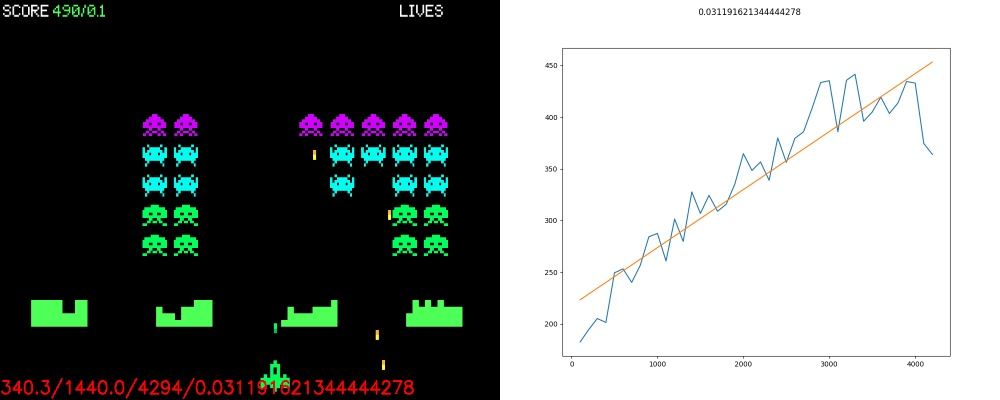

1 [[ 900.0432  1313.8458   928.2146   911.61896]]
1 [[ 900.04333 1313.846    928.2147   911.619  ]]
1 [[ 900.0432  1313.8458   928.21466  911.61896]]
1 [[ 900.04333 1313.846    928.2147   911.61896]]
1 [[ 900.04333 1313.8458   928.21466  911.61896]]
1 [[ 900.0432  1313.8458   928.21466  911.61896]]
1 [[ 900.0432  1313.8458   928.21466  911.61896]]
1 [[ 900.04333 1313.846    928.21466  911.619  ]]
1 [[ 900.0432  1313.8458   928.21466  911.61896]]
1 [[ 900.04333 1313.8458   928.21466  911.61896]]
1 [[ 900.0432  1313.8458   928.2146   911.61896]]


KeyboardInterrupt: 

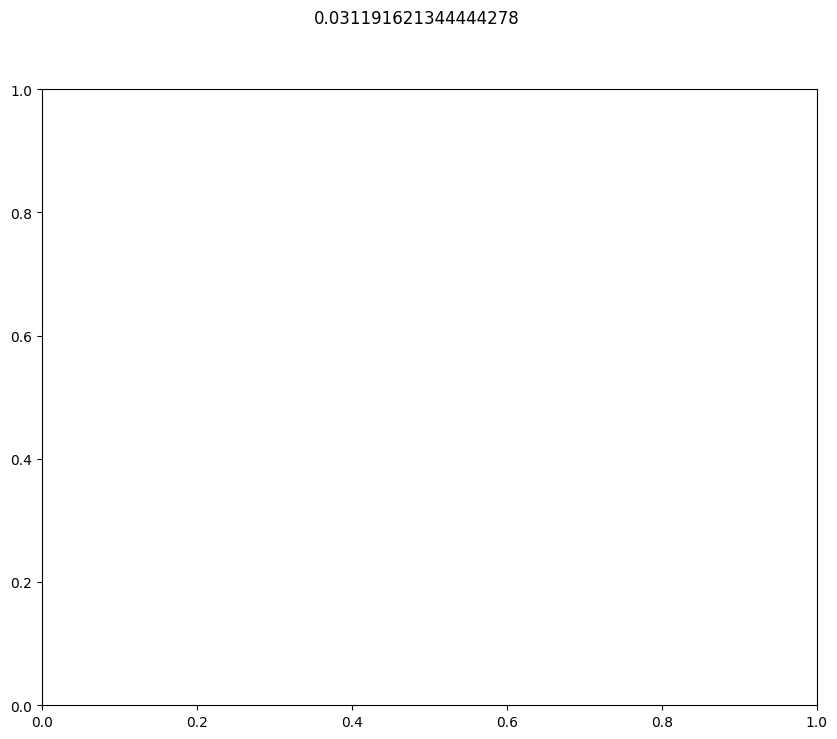

In [14]:
display_handle = display(None, display_id=True)
fig, ax = plt.subplots(figsize=(10, 8))
display_fig = True
display_cnt = 0
display_res = 10
plt.ion()

while True:
  game.start()
  episode_count += 1
  game_reward = 0
  done = False
  while not done:
    new_action, state, action, reward, new_state, done = agent.play(game)
    if new_action:
      display_cnt += 1
      if display_fig and (done or display_cnt % display_res == 0):
        asyncio.run(update_screen(display_handle, SCREEN, sum_score, stats, fig, ax))

      agent.remember(state, action, reward, new_state, done)
      agent.memory_count += 1
      agent.train_step += 1
      if agent.train_step % agent.train_step_update == 0:
        agent.target_model.load_state_dict(agent.model.state_dict())
        agent.train_step = 0
      if agent.memory_count >= 50:
        batch = min(len(game.agent.memory), BATCH_SIZE)
        game_reward += agent.replay(batch)

    if done:
      agent.clear()
      sum_score = np.append(sum_score, game.score)

  stats = np.append(stats, np.array([game.score, agent.epsilon, game_reward]))
  np.savetxt(STATS_FILE, stats)
  agent.save(MODEL_FILE)
  gc.collect()

### References

Title: Deep Reinforcement Learning to play Space Invaders
Link: https://nihit.github.io/resources/spaceinvaders.pdf
Type: Paper

Title: Frame Skipping and Pre-Processing for Deep Q-Networks on Atari 2600 Games
Link: https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
Type: Blog Post

Title: GuarDiqN: Playing Space Invader with Dueling Double Deep Q-Network
Link: https://github.com/lychengrex/Playing-Space-Invaders-with-Deep-Q-Networks/tree/master
Type: Source Code

Title: Improving the DQN algorithm using Double Q-Learning
Link: https://davidrpugh.github.io/stochastic-expatriate-descent/pytorch/deep-reinforcement-learning/deep-q-networks/2020/04/11/double-dqn.html
Type: Blog Post

Title: Double Q-learning
Link: https://proceedings.neurips.cc/paper_files/paper/2010/file/091d584fced301b442654dd8c23b3fc9-Paper.pdf
Type: Paper

Title: Deep reinforcement learning with pixel features in Atari Pong Game
Link: https://github.com/gznyyb/deep_reinforcement_learning_Pong/tree/master
Type: Source Code

Title: TRAIN A MARIO-PLAYING RL AGENT
Link: https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
Type: Blog Post

Title: Playing Super Mario Bros with Deep Reinforcement Learning
Link: https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
Type: Blog Post

Title: Deep Reinforcement Learning with Space Invaders… Literally from scratch
Link: https://yaassinekaddi.medium.com/deep-reinforcement-learning-with-space-invaders-literally-from-scratch-part-i-10905fe04846
Type: Blog Post

Title: Asynchronous Methods for Deep Reinforcement Learning
Link: https://arxiv.org/pdf/1602.01783.pdf
Type: Paper

Title: Reinforcement-Learning-Atari-Games
Link: https://github.com/NitishMutha/Reinforcement-Learning-Atari-Games/tree/master
Type: Source Code

Title: Practical Reinforcement Learning — 02 Getting started with Q-learning
Link: https://towardsdatascience.com/practical-reinforcement-learning-02-getting-started-with-q-learning-582f63e4acd9
Type: Blog Post

Title: Playing Atari with Deep Reinforcement Learning
Link: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
Type: Paper

Title: RL
Link: https://github.com/msachin93/RL
Type: Source Code

Title: Space Invaders challenge: a Reinforcement Learning competition
Link: https://wandb.ai/raghmura/qualcomm/reports/Space-Invaders-challenge-a-Reinforcement-Learning-competition--Vmlldzo5MzEzMg
Type: Blog Post